# Quickeats
## Ivan Chavez, Uyen Pham, & Lane Whitmore
### ADS-599 Capstone Project
### Shiley-Marcos School of Engineering - University of San Diego
### Professor Graindorge

In [2]:
# imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import random
%matplotlib inline
import seaborn as sns; sns.set() # for plot styling
import numpy as np
import tarfile
from io import BytesIO
from zipfile import ZipFile
from time import time
import sklearn
from sklearn.pipeline import Pipeline
from skimage import io
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib.image import imread
import glob
import random
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import mahotas.features.texture as texture
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import h5py

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Import Data

In [5]:
directory = "/Users/whitm/.fastai/data/food-101"
image_list = []
folder_names = []
# Get a list of all subdirectories in the given directory
subdirectories = [f.path for f in os.scandir(directory+ "/images") if f.is_dir()]

# Loop through each subdirectory
for subdirectory in subdirectories:
    # Get the folder name
    folder_name = os.path.basename(subdirectory)

    # Get a list of all image files within the subdirectory
    image_files = [f.path for f in os.scandir(subdirectory) if f.is_file() and f.name.endswith(".jpg")]

    # Loop through each image file
    for image_file in image_files:
        # Append the image file to the image_list
        image_list.append(image_file)
        folder_names.append(folder_name)

In [6]:
labels_file = directory+'/labels.txt'
with open(labels_file, 'r') as f:
    labels = [label.strip().lower().replace(' ', '_') for label in f.readlines()]

In [7]:
print("Total Image Count in Dataset:", len(image_list))

Total Image Count in Dataset: 101000


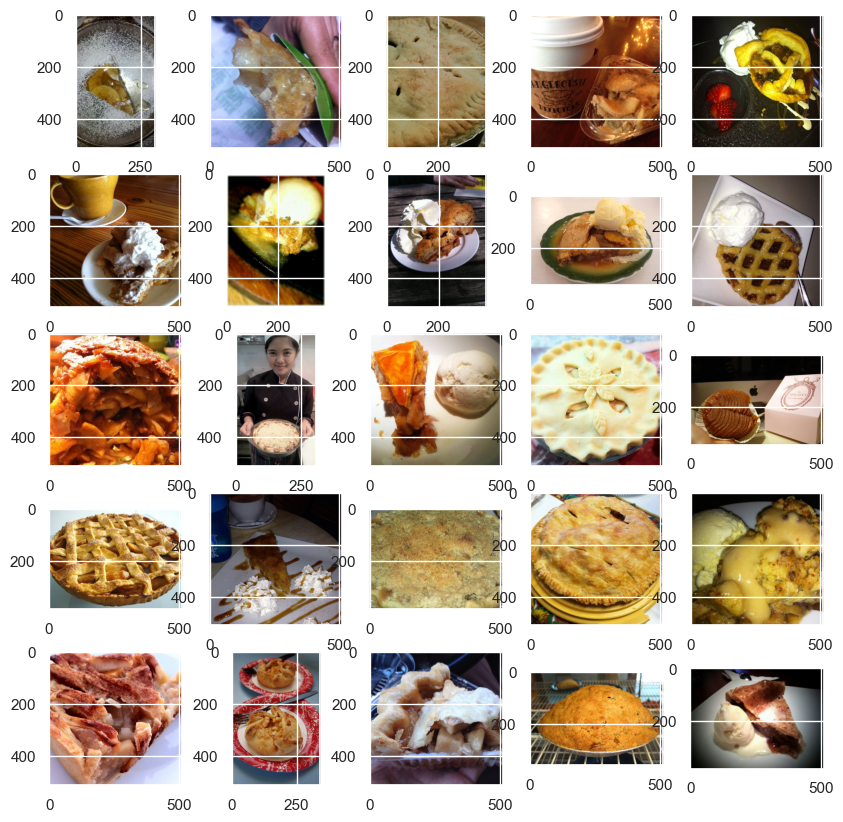

In [8]:
#plot the example images
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = ax.flatten()
for i in range(25):
    path=image_list[i]
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img, cmap=None)

## Train // Test Split

The dataset has been pre-split as some of the images have required manual removal. Due to the time limitations with this project, we are going to be unable to manually search through over 100,000 images and therefore will rely on the FastAI split to remove any potential bias from our testing set.

In [9]:
# Load the category labels
labels_file = directory+'/labels.txt'
with open(labels_file, 'r') as f:
    labels = [label.strip().lower().replace(' ', '_') for label in f.readlines()]

# Load the training dataset
train_file = directory+'/train.txt'
train_data = pd.read_csv(train_file, header=None, names=['category_filename'], dtype=str)
train_data['category'] = train_data['category_filename'].apply(lambda x: x.split('/')[0])
train_data['filename'] = train_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
train_data['filename'] = train_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
train_data['image_path'] = train_data.apply(lambda row: os.path.join(directory, 'images', row['category'], row['filename']), axis=1)

print (train_data.shape)
train_data.head()

(75750, 4)


category_filename   category     filename  \
0  apple_pie/1005649  apple_pie  1005649.jpg   
1  apple_pie/1014775  apple_pie  1014775.jpg   
2  apple_pie/1026328  apple_pie  1026328.jpg   
3  apple_pie/1028787  apple_pie  1028787.jpg   
4  apple_pie/1043283  apple_pie  1043283.jpg   

                                          image_path  
0  /Users/whitm/.fastai/data/food-101\images\appl...  
1  /Users/whitm/.fastai/data/food-101\images\appl...  
2  /Users/whitm/.fastai/data/food-101\images\appl...  
3  /Users/whitm/.fastai/data/food-101\images\appl...  
4  /Users/whitm/.fastai/data/food-101\images\appl...

In [10]:
# Load the test dataset
test_file = directory+'/test.txt'
test_data = pd.read_csv(test_file, header=None, names=['category_filename'], dtype=str)
test_data['category'] = test_data['category_filename'].apply(lambda x: x.split('/')[0])
test_data['filename'] = test_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
test_data['filename'] = test_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
test_data['image_path'] = test_data.apply(lambda row: os.path.join(directory, 'images', row['category'], row['filename']), axis=1)

print (test_data.shape)
test_data.head()

(25250, 4)


category_filename   category     filename  \
0  apple_pie/1011328  apple_pie  1011328.jpg   
1   apple_pie/101251  apple_pie   101251.jpg   
2  apple_pie/1034399  apple_pie  1034399.jpg   
3   apple_pie/103801  apple_pie   103801.jpg   
4  apple_pie/1038694  apple_pie  1038694.jpg   

                                          image_path  
0  /Users/whitm/.fastai/data/food-101\images\appl...  
1  /Users/whitm/.fastai/data/food-101\images\appl...  
2  /Users/whitm/.fastai/data/food-101\images\appl...  
3  /Users/whitm/.fastai/data/food-101\images\appl...  
4  /Users/whitm/.fastai/data/food-101\images\appl...

In [11]:
print("Amount of Training Set Images:", len(train_data))
print("Amount of Testing Set Images:", len(test_data))

Amount of Training Set Images: 75750
Amount of Testing Set Images: 25250


## Exploratory Data Analysis

Now that the data has been separated into training and testing sets, the EDA will be performed on our training set.

### Observing Random Categories

In [29]:
for _, i in train_data.groupby('category').apply(lambda x: x.sample(1)).iterrows():
    print(i['image_path'])

/Users/whitm/.fastai/data/food-101\images\apple_pie\1043283.jpg
/Users/whitm/.fastai/data/food-101\images\baby_back_ribs\1005293.jpg
/Users/whitm/.fastai/data/food-101\images\baklava\675112.jpg
/Users/whitm/.fastai/data/food-101\images\beef_carpaccio\2103010.jpg
/Users/whitm/.fastai/data/food-101\images\beef_tartare\3692683.jpg
/Users/whitm/.fastai/data/food-101\images\beet_salad\66574.jpg
/Users/whitm/.fastai/data/food-101\images\beignets\3261933.jpg
/Users/whitm/.fastai/data/food-101\images\bibimbap\2292732.jpg
/Users/whitm/.fastai/data/food-101\images\bread_pudding\422911.jpg
/Users/whitm/.fastai/data/food-101\images\breakfast_burrito\1216345.jpg
/Users/whitm/.fastai/data/food-101\images\bruschetta\3439196.jpg
/Users/whitm/.fastai/data/food-101\images\caesar_salad\2039808.jpg
/Users/whitm/.fastai/data/food-101\images\cannoli\1089515.jpg
/Users/whitm/.fastai/data/food-101\images\caprese_salad\2477645.jpg
/Users/whitm/.fastai/data/food-101\images\carrot_cake\3767582.jpg
/Users/whitm/.

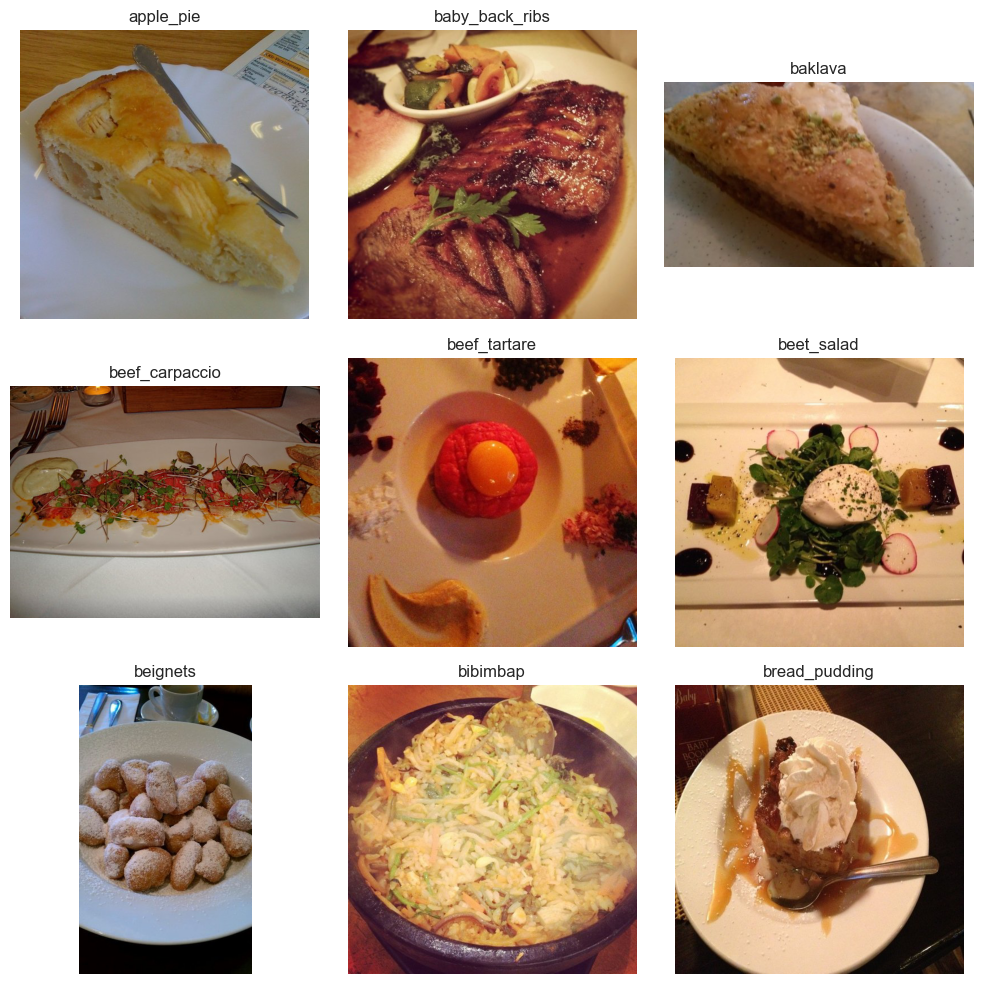

In [30]:
# Load a random sample of images from different categories
sample_images = train_data.groupby('category').apply(lambda x: x.sample(1))
sample_images_paths = []
for _, row in sample_images.iterrows():
    category = row['category']
    image_path = row['image_path']
    #image_path = f'{directory}/images/{category}/{filename}'
    sample_images_paths.append(image_path)

plt.figure(figsize=(10, 10))
num_images = min(len(sample_images_paths), 9)
num_rows = num_cols = int(num_images ** 0.5)
for i, image_path in enumerate(sample_images_paths[:num_images]):
    plt.subplot(num_rows, num_cols, i+1)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(image)  # Display the image
    plt.title(sample_images.iloc[i]['category'])
    plt.axis('off')
plt.tight_layout()
plt.show()

#### Observe images from apple pie category

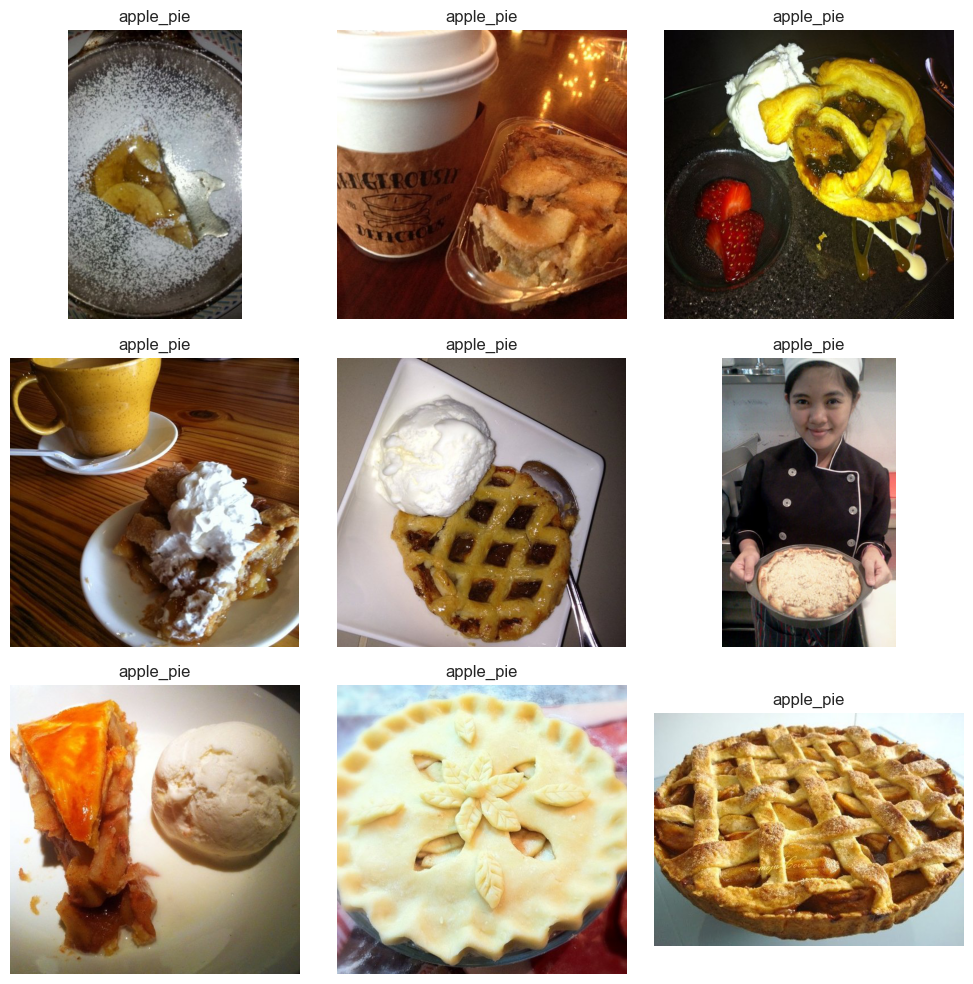

In [31]:
# Specify the category you want to plot
category_to_plot = "apple_pie"

# Filter the train_data based on the specified category
category_data = train_data[train_data['category'] == category_to_plot]

plt.figure(figsize=(10, 10))
num_images = min(len(category_data), 9)
num_rows = num_cols = int(num_images ** 0.5)
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    image_path = category_data.iloc[i]['image_path']
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(image)  # Display the image
    plt.title(category_to_plot)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Explore the Distribution of Image Size

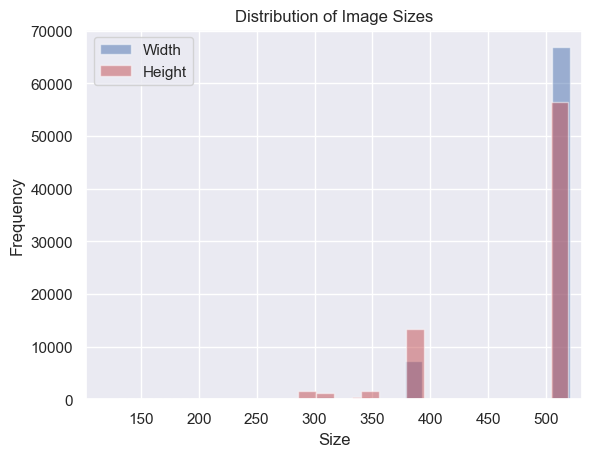

In [32]:
# Distribution of image sizes
image_sizes = []
for image_path in train_data['image_path']:
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    image_sizes.append((width, height))
    
#plot the distribution
widths, heights = zip(*image_sizes)
plt.hist(widths, bins=50, alpha=0.5, color='b', label='Width', width=15)
plt.hist(heights, bins=50, alpha=0.5, color='r', label='Height', width=15)
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Image Sizes')
plt.show()

 --> Most images have high values of height and width around 525 pixels, another size shows the next high frequency is around 375 pixels.

### Explore the distribution of mean intensity and contrast of categories

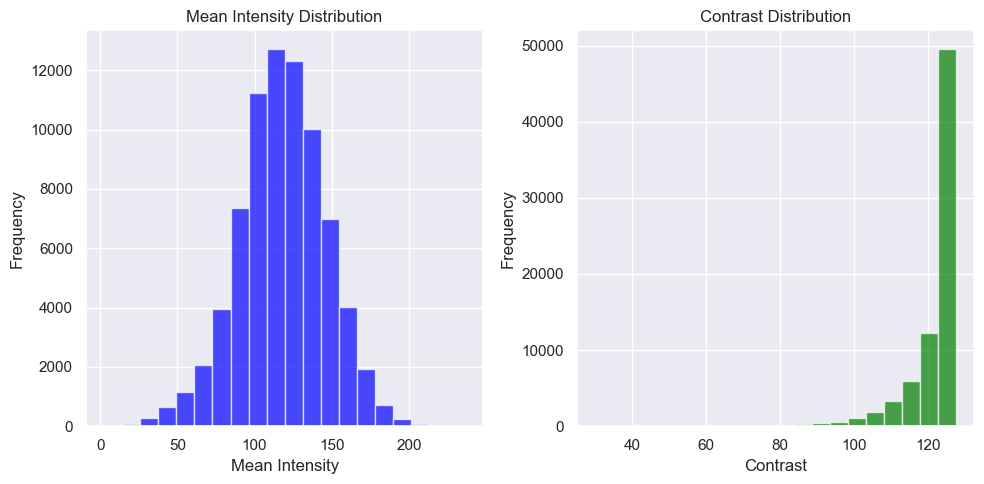

In [21]:
# Compute the mean intensity and contrast of images in the train_data dataset
mean_intensities = []
contrasts = []

for _, row in train_data.iterrows():
    image_path = row['image_path']
    
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute the mean intensity
    mean_intensity = np.mean(gray)
    mean_intensities.append(mean_intensity)
    
    # Compute the contrast
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contrast = np.std(thresholded)
    contrasts.append(contrast)

# Plot the mean intensity and contrast
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(mean_intensities, bins=20, color='blue', alpha=0.7)
plt.title('Mean Intensity Distribution')
plt.xlabel('Mean Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(contrasts, bins=20, color='green', alpha=0.7)
plt.title('Contrast Distribution')
plt.xlabel('Contrast')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

-->The mean intensity shows normal distribution of all images while contrast shows left skew distribution

### Explore the distribution of mean intensity and contrast values  for random 5 categories

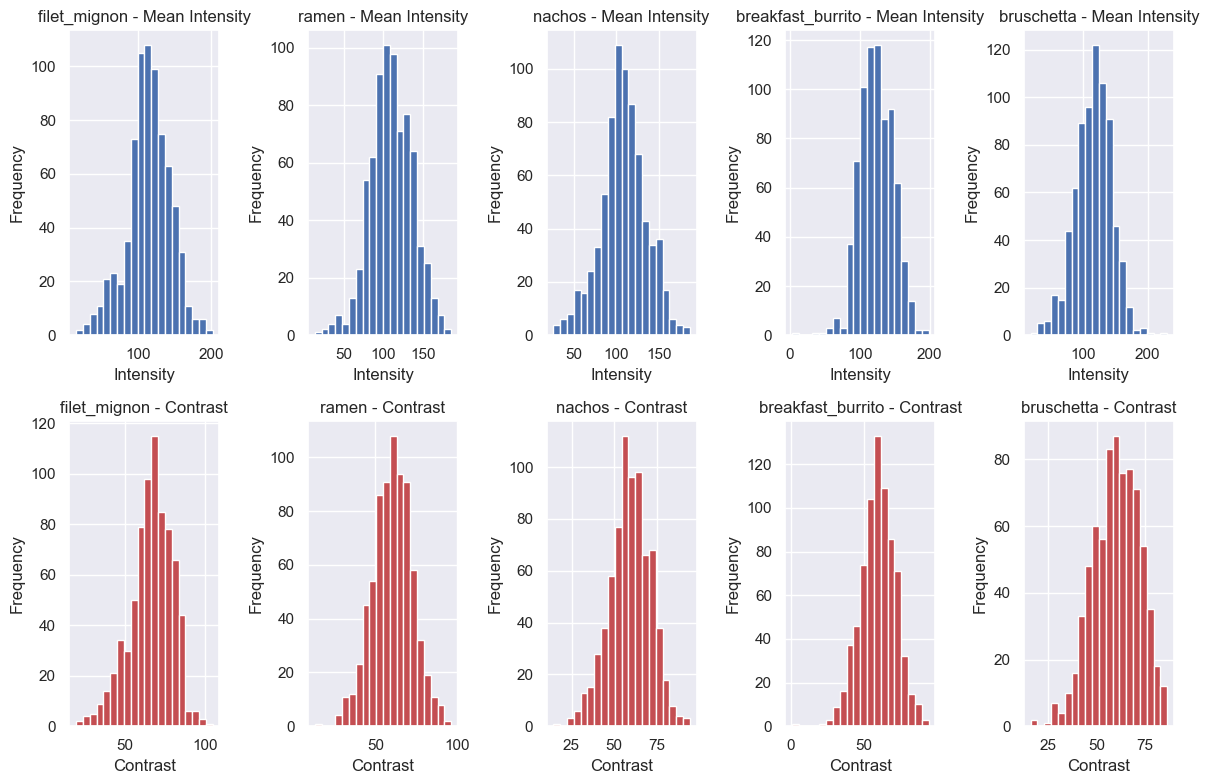

In [22]:
# Randomly select a subset of categories
num_categories = 5  
selected_categories = random.sample(labels, num_categories)

# Calculate and plot intensity and contrast for each category
plt.figure(figsize=(12, 8))
for i, category in enumerate(selected_categories):
    category_data = train_data[train_data['category'] == category]
    image_paths = category_data['image_path'].tolist()
    
    mean_intensities = []
    contrasts = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        intensity = np.mean(gray) 
        contrast = np.std(gray) 
        mean_intensities.append(intensity)
        contrasts.append(contrast)
        
    plt.subplot(2, num_categories, i + 1)
    plt.hist(mean_intensities, bins=20, color='b')
    plt.title(f'{category} - Mean Intensity')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')

    plt.subplot(2, num_categories, num_categories + i + 1)
    plt.hist(contrasts, bins=20, color='r')
    plt.title(f'{category} - Contrast')
    plt.xlabel('Contrast')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

 --> The distribution of mean intensity and contrast in each category selected randomly show normal or close to normal ditribution. 

### Explore the texture of the images from each category

In [127]:
# Function to compute Haralick texture features for an image
def compute_haralick_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = texture.haralick(gray)
    features = haralick.mean(axis=0)
    return features

# Analyze texture features for each category
texture_features = []
for category in labels:
    category_data = train_data[train_data['category'] == category]
    image_paths = category_data['image_path'].tolist()
    
    for image_path in image_paths:
        image = cv2.imread(image_path)
        features = compute_haralick_features(image)
        texture_features.append(features)

In [128]:
texture_features[:5]

[array([ 1.69286290e-04,  2.35126980e+02,  9.55430016e-01,  2.63855958e+03,
         1.48630247e-01,  2.30281812e+02,  1.03191114e+04,  8.60498668e+00,
         1.31818615e+01,  1.85279741e-04,  4.82805422e+00, -2.68665863e-01,
         9.90988830e-01]),
 array([ 6.16319257e-04,  7.68535474e+01,  9.91248587e-01,  4.39187776e+03,
         2.97963145e-01,  2.01227192e+02,  1.74906575e+04,  8.70218243e+00,
         1.21462938e+01,  4.30574689e-04,  3.76183972e+00, -4.26244489e-01,
         9.99229564e-01]),
 array([ 1.03076011e-03,  1.74537553e+02,  9.82190822e-01,  4.89970615e+03,
         2.80742476e-01,  1.41525625e+02,  1.94242871e+04,  8.12509429e+00,
         1.18830109e+01,  3.34708057e-04,  4.19765944e+00, -3.36927254e-01,
         9.95719895e-01]),
 array([ 4.61236704e-04,  1.11746178e+02,  9.86016400e-01,  3.99553893e+03,
         2.65626945e-01,  1.82349505e+02,  1.58704095e+04,  8.59506169e+00,
         1.22645381e+01,  3.79490564e-04,  3.95247424e+00, -3.87064013e-01,
       

In [135]:
# Create a dataframe with texture features and labels
df_texture = pd.DataFrame(texture_features, columns=['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 
                                                     'Feature 5', 'Feature 6', 'Feature 7', 'Feature 8', 
                                                     'Feature 9', 'Feature 10', 'Feature 11', 'Feature 12', 
                                                     'Feature 13'])  # Replace with actual feature names
df_texture['Category'] = train_data['category']

# Compute the average texture feature values for each category
df_mean = df_texture.groupby('Category').mean()

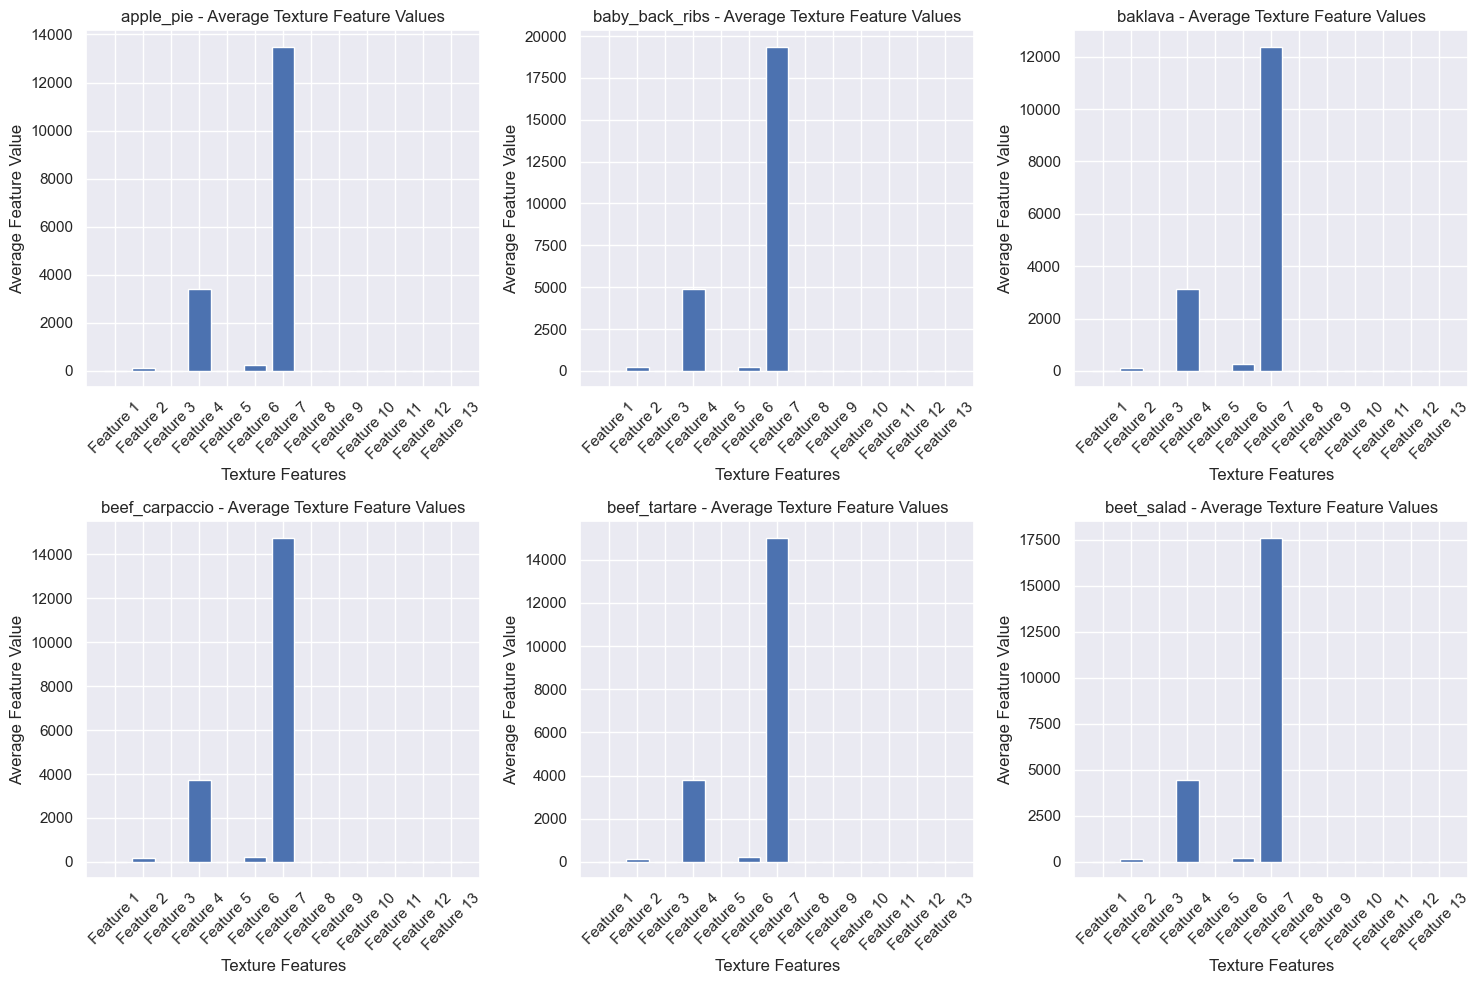

In [136]:
# Observe texture feature distibution for some categories 
num_categories_to_plot = 6 

plt.figure(figsize=(15, 10))

for i, category in enumerate(df_mean.index[:num_categories_to_plot]):
    plt.subplot(2, 3, i+1)
    plt.bar(df_mean.columns, df_mean.loc[category])
    plt.title(f'{category} - Average Texture Feature Values')
    plt.xlabel('Texture Features')
    plt.ylabel('Average Feature Value')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

Prominent features in the plot are:

Haralick Texture Feature 4: Sum of Squares Variance - It captures the variance of pixel intensities in the image.
Haralick Texture Feature 7: Sum Variance - It captures the variance of the sum values of local image regions.

--> The first 6 categories plots indicate distinct patterns and textures in the image and highlight contrast and variations in intensity or brightness

## Creating datasets for modeling training and testing

To evaluate each epoch of the models as they iterate, a validation set will be created with 15% of the testing set. The testing set does not contain bias leftover in the training and therefore makes logical sense to pick from. 

In [138]:
datagen = keras.preprocessing.image.ImageDataGenerator()

# data generators also can handle image augmentation for each model iteration
datagen_aug = keras.preprocessing.image.ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

In [13]:
# creating validation set with 15% of the testing data to avoid potential bias in the training set
testgen = keras.preprocessing.image.ImageDataGenerator(validation_split=0.15)

In [14]:
train_gen_aug = datagen_aug.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='category',
    target_size = (224,224),
    batch_size = 32,
    color_mode='rgb',
    shuffle=True,
    seed=33
)

train_gen = datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='category',
    target_size = (224,224),
    batch_size = 32,
    color_mode='rgb',
    shuffle=True,
    seed=33
)

Found 75750 validated image filenames belonging to 101 classes.
Found 75750 validated image filenames belonging to 101 classes.


In [15]:
test_gen = testgen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='category',
    target_size = (224,224),
    color_mode='rgb',
    batch_size = 1,
    shuffle = False,
    seed=33,
    subset='training'
)

val_gen = testgen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='category',
    target_size = (224,224),
    color_mode='rgb',
    batch_size = 32,
    shuffle = False,
    seed=33,
    subset='validation'
)

Found 21463 validated image filenames belonging to 101 classes.
Found 3787 validated image filenames belonging to 101 classes.


### Looking at Tensors, Arrays from Generators for training / testing / validation

In [16]:
arrays, value = train_gen.next()
print(arrays[0].shape)

(224, 224, 3)


In [169]:
arrays[0][0]

array([[ 97., 106.,  89.],
       [ 99., 106.,  90.],
       [100., 104.,  89.],
       [109., 111.,  97.],
       [104., 111.,  95.],
       [103., 114.,  97.],
       [ 99., 114.,  95.],
       [102., 110.,  95.],
       [104., 112.,  99.],
       [107., 119., 105.],
       [105., 119., 104.],
       [105., 117., 105.],
       [104., 116., 104.],
       [105., 115., 104.],
       [102., 114., 102.],
       [ 98., 110.,  98.],
       [ 97., 109.,  95.],
       [ 98., 109.,  95.],
       [ 95., 103.,  88.],
       [ 95., 102.,  86.],
       [ 94., 101.,  85.],
       [102., 109.,  93.],
       [102., 109.,  93.],
       [100., 109.,  92.],
       [ 91., 100.,  83.],
       [ 95., 106.,  89.],
       [102., 113.,  96.],
       [104., 115.,  98.],
       [108., 116., 101.],
       [105., 113.,  98.],
       [102., 113.,  97.],
       [103., 116.,  99.],
       [ 98., 112.,  97.],
       [101., 115., 100.],
       [107., 121., 106.],
       [112., 128., 118.],
       [108., 124., 114.],
 

These sample arrays are the mathematical representations of images that the model will see. The convolution layers will use these representations to abstract the images and pull the mathematical representation that the weights deem the most important. Modeling will require multiple epochs as the weights are formed by adding bias to the model over multiple iterations while hoping to come to a convergence point where the model is neither over or under fit. 

### Sample Data Augmentation for Modeling

In [142]:
sampdatagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

# data generators also can handle image augmentation for each model iteration
sampdatagen_aug = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

In [165]:
sample_orig = sampdatagen.flow_from_dataframe(train_data[0:25],
                                         x_col='image_path',
                                         y_col='category',
                                         target_size = (224,224),
                                         batch_size = 32,
                                         color_mode='rgb',
                                         shuffle=False,
                                         seed=33)

sample_aug = sampdatagen_aug.flow_from_dataframe(train_data[0:25],
                                             x_col='image_path',
                                             y_col='category',
                                             target_size = (224,224),
                                             batch_size = 32,
                                             color_mode='rgb',
                                             shuffle=False,
                                             seed=33)

Found 25 validated image filenames belonging to 1 classes.
Found 25 validated image filenames belonging to 1 classes.


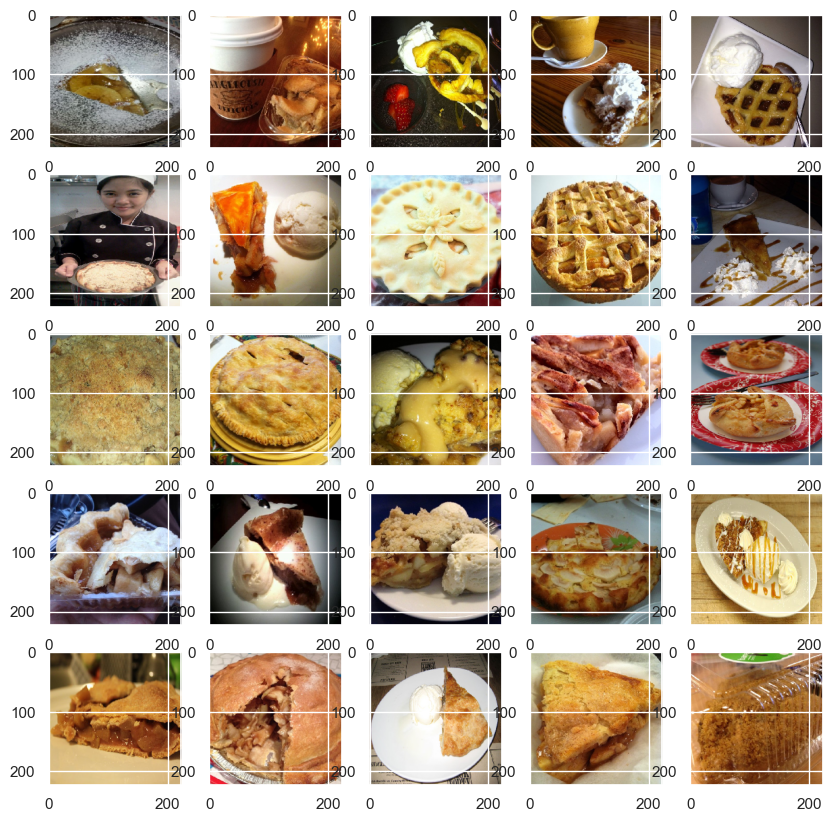

In [166]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = ax.flatten()
origarray, valueor = sample_orig.next()
for i in range(0, 25):
    img=origarray[i]
    axes[i].imshow(img, cmap=None)

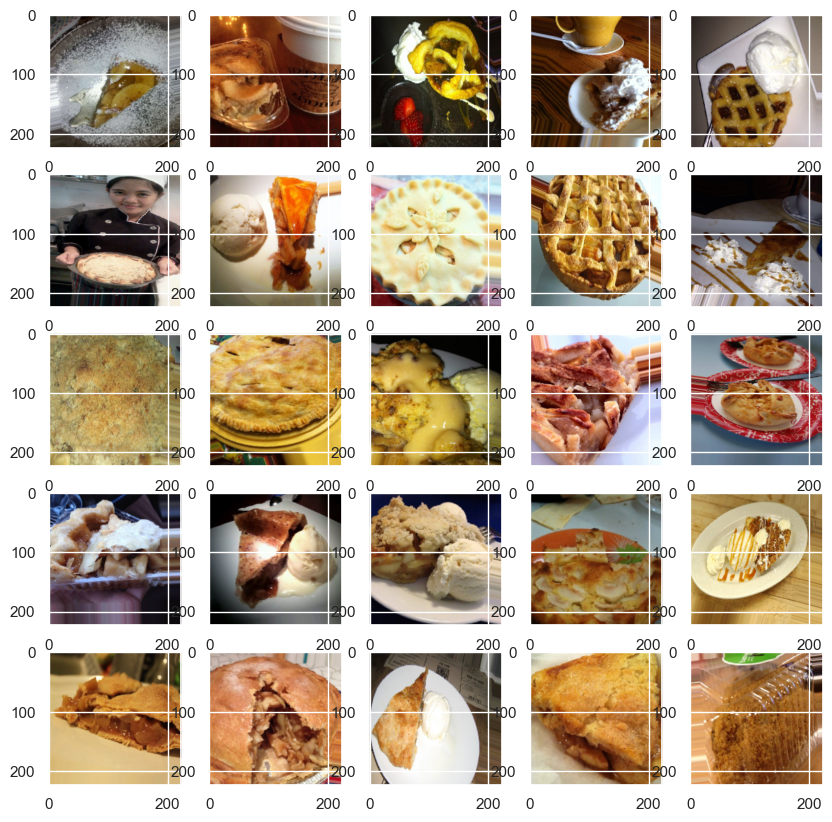

In [167]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = ax.flatten()
augarray, valueor = sample_aug.next()
for i in range(0, 25):
    img=augarray[i]
    axes[i].imshow(img, cmap=None)

The data will be slightly augmented similar to here. The hope is the realistic variations will prevent the CNNs from overfitting to the data. Keeping the augmentation to realistic alterations also removes bias from highly altered images. 

## Modeling

In [21]:
# setting parameters for model construction
input_shape=(224,224,3)
batch_size = 32

### MobileNetV3

In [25]:
checkpoint_filepath = '../models/mobilenetv3/checkpoints/checkpoint.ckpt'
mobile_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch')

In [26]:
# Create a custom callback to capture the training history
class TrainingHistoryCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    def on_epoch_end(self, epoch, logs=None):
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))

# Initialize the custom callback
training_history_callback = TrainingHistoryCallback()
# Train the model with early stopping and learning rate reduction callbacks
epochs = 4
fine_tune_epochs = 8  # Number of epochs for fine-tuning

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3)

# Load MobileNetV3Small model without top layers and freeze the pre-trained layers
base_model = keras.applications.MobileNetV3Large(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
predictions = keras.layers.Dense(101, activation='softmax')(x)

mobilenet_v3 = keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower learning rate for fine-tuning
learning_rate = 0.0001
mobilenet_v3.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the custom layers and the last layer
mobilenet_v3_pre = mobilenet_v3.fit(
    train_gen_aug,
    steps_per_epoch=train_gen_aug.n // batch_size,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping, lr_scheduler, training_history_callback, mobile_checkpoint_callback]
)
# Unfreeze some of the later layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Recreate the model after unfreezing layers
mobilenet_v3_pre = keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model after unfreezing layers with a lower learning rate for fine-tuning
fine_tune_learning_rate = 0.0001
mobilenet_v3_pre.compile(optimizer=keras.optimizers.Adam(learning_rate=fine_tune_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with a lower learning rate for fine-tuning
mb_history = mobilenet_v3_pre.fit(
    train_gen_aug,
    steps_per_epoch=train_gen_aug.n // batch_size,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    epochs=fine_tune_epochs, 
    callbacks=[early_stopping, lr_scheduler, training_history_callback, mobile_checkpoint_callback]
)

Epoch 1/4
2367/2367 [==============================] - 822s 346ms/step - loss: 2.3398 - accuracy: 0.4411 - val_loss: 1.5791 - val_accuracy: 0.5903 - lr: 1.0000e-04
Epoch 2/4
2367/2367 [==============================] - 804s 340ms/step - loss: 1.5941 - accuracy: 0.5926 - val_loss: 1.3889 - val_accuracy: 0.6181 - lr: 1.0000e-04
Epoch 3/4
2367/2367 [==============================] - 808s 341ms/step - loss: 1.4328 - accuracy: 0.6306 - val_loss: 1.2990 - val_accuracy: 0.6472 - lr: 1.0000e-04
Epoch 4/4
2367/2367 [==============================] - 805s 340ms/step - loss: 1.3373 - accuracy: 0.6511 - val_loss: 1.3304 - val_accuracy: 0.6414 - lr: 1.0000e-04
Epoch 1/8
2367/2367 [==============================] - 835s 350ms/step - loss: 1.2587 - accuracy: 0.6712 - val_loss: 1.0689 - val_accuracy: 0.6999 - lr: 1.0000e-04
Epoch 2/8
2367/2367 [==============================] - 835s 353ms/step - loss: 0.9141 - accuracy: 0.7514 - val_loss: 0.9485 - val_accuracy: 0.7362 - lr: 1.0000e-04
Epoch 3/8
2367/2

In [27]:
mobile_loss, mobile_accuracy = mobilenet_v3_pre.evaluate(test_gen)

21463/21463 [==============================] - 231s 11ms/step - loss: 0.7908 - accuracy: 0.8026


In [41]:
print("Overall MobileNetV3 Accuracy: ", round(mobile_accuracy*100, 2) , "%")

Overall MobileNetV3 Accuracy:  80.26 %


In [129]:
mobilenet_v3_pre.save('../models/mobilenetV3/tuned_model')

INFO:tensorflow:Assets written to: ../models/mobilenetV3/tuned_model\assets


INFO:tensorflow:Assets written to: ../models/mobilenetV3/tuned_model\assets


### EfficientNetB0

In [29]:
def model_checkpoint_callback(dir):
    model_checkpoint_callback =  tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=dir,
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    monitor='val_Accuracy',
                                                    mode='max',
                                                    save_freq='epoch')
    return model_checkpoint_callback

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [35]:
checkpoint_fp = '../models/eff_net/checkpoints/checkpoint.ckpt'

effb0_model = tf.keras.applications.EfficientNetB0(include_top=False)
effb0_model.trainable=False

inputs = layers.Input(shape= input_shape, name='input_layer')


x = effb0_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(labels)) (x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

efficient = tf.keras.Model(inputs, outputs)

efficient.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(), metrics=['Accuracy'])

hist_effb0_1 = efficient.fit(train_gen,
                        epochs=4,
                        steps_per_epoch=len(train_gen),
                        validation_data=val_gen,
                        validation_steps=len(val_gen),
                        callbacks=model_checkpoint_callback(checkpoint_fp)
                        )

Epoch 1/4
2368/2368 [==============================] - 291s 121ms/step - loss: 1.7224 - Accuracy: 0.5814 - val_loss: 1.3415 - val_Accuracy: 0.6403
Epoch 2/4
2368/2368 [==============================] - 291s 123ms/step - loss: 1.2034 - Accuracy: 0.6881 - val_loss: 1.2514 - val_Accuracy: 0.6652
Epoch 3/4
2368/2368 [==============================] - 294s 124ms/step - loss: 1.0572 - Accuracy: 0.7237 - val_loss: 1.1103 - val_Accuracy: 0.6992
Epoch 4/4
2368/2368 [==============================] - 292s 123ms/step - loss: 0.9632 - Accuracy: 0.7466 - val_loss: 1.0848 - val_Accuracy: 0.7035


In [36]:
effb0_model.trainable=True
efficient.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['Accuracy'])


In [37]:
checkpoint_fp = '../models/eff_net/checkpoints/checkpoint_tune.ckpt'

hist_effb0_1_fine_tune_all = efficient.fit(train_gen,
                                           epochs=9, # fine tune for an additional 4 epochs
                                           steps_per_epoch=len(train_gen),
                                           validation_data=train_gen,
                                           validation_steps=len(val_gen),
                                           initial_epoch=hist_effb0_1.epoch[-1], # start training from last trained epoch in this case training starts at epoch 4
                                           callbacks=[model_checkpoint_callback(checkpoint_fp), callback]
                                     )

Epoch 4/9
2368/2368 [==============================] - 341s 141ms/step - loss: 0.8316 - Accuracy: 0.7740 - val_loss: 0.5138 - val_Accuracy: 0.8674
Epoch 5/9
2368/2368 [==============================] - 329s 139ms/step - loss: 0.5172 - Accuracy: 0.8563 - val_loss: 0.2637 - val_Accuracy: 0.9380
Epoch 6/9
2368/2368 [==============================] - 338s 143ms/step - loss: 0.2921 - Accuracy: 0.9160 - val_loss: 0.1501 - val_Accuracy: 0.9609
Epoch 7/9
2368/2368 [==============================] - 340s 144ms/step - loss: 0.1562 - Accuracy: 0.9536 - val_loss: 0.0899 - val_Accuracy: 0.9745
Epoch 8/9
2368/2368 [==============================] - 330s 139ms/step - loss: 0.1007 - Accuracy: 0.9686 - val_loss: 0.0770 - val_Accuracy: 0.9756
Epoch 9/9
2368/2368 [==============================] - 327s 138ms/step - loss: 0.0767 - Accuracy: 0.9761 - val_loss: 0.0763 - val_Accuracy: 0.9753


In [38]:
eff_loss, eff_accuracy = efficient.evaluate(test_gen)

21463/21463 [==============================] - 275s 13ms/step - loss: 1.1888 - Accuracy: 0.7713


In [40]:
print("Overall EfficientNetB0 Accuracy: ", round(eff_accuracy*100, 2) , "%")

Overall EfficientNetB0 Accuracy:  77.13 %


In [ ]:
efficient.save('../models/eff_net/tuned_model')

### InceptionV3

In [42]:
checkpoint_filepath = '../models/inception/checkpoints/checkpoint.ckpt'
inception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_Accuracy',
    mode='max',
    save_freq='epoch')

In [44]:
incept = tf.keras.applications.InceptionV3(include_top=False)

incept.trainable=False

inputs = layers.Input(shape= input_shape, name='input_layer')

# This model requires scaling before training / keras has a built in method to do so
x = tf.keras.applications.inception_v3.preprocess_input(inputs)

x = incept(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(101)(x)
outputs = keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

inception = tf.keras.Model(inputs, outputs)

inception.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(), metrics=['Accuracy'])

In [47]:
hist_inception = inception.fit(train_gen_aug,
                                epochs=4,
                                steps_per_epoch=len(train_gen_aug),
                                validation_data=val_gen,
                                validation_steps=len(val_gen),
                                callbacks=inception_checkpoint_callback
                                )

Epoch 1/4
2368/2368 [==============================] - 861s 363ms/step - loss: 2.2820 - Accuracy: 0.4597 - val_loss: 2.3912 - val_Accuracy: 0.4183
Epoch 2/4
2368/2368 [==============================] - 841s 355ms/step - loss: 2.1868 - Accuracy: 0.4799 - val_loss: 2.2995 - val_Accuracy: 0.4473
Epoch 3/4
2368/2368 [==============================] - 842s 355ms/step - loss: 2.1191 - Accuracy: 0.4934 - val_loss: 2.1301 - val_Accuracy: 0.4743
Epoch 4/4
2368/2368 [==============================] - 841s 355ms/step - loss: 2.0842 - Accuracy: 0.5017 - val_loss: 2.2469 - val_Accuracy: 0.4587


#### Fine-Tuning InceptionV3

In [48]:
incept.trainable=True

#for layer in incept.layers[:-25]:
    #layer.trainable = False
inception.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=['Accuracy'])

In [50]:
hist_inception_fine_tune25 = inception.fit(train_gen_aug,
                                            epochs=10,
                                            steps_per_epoch=len(train_gen_aug),
                                            validation_data=val_gen,
                                            validation_steps=len(val_gen),
                                            initial_epoch=hist_inception.epoch[-1] + 1, 
                                            callbacks=[inception_checkpoint_callback, callback]
                        )

Epoch 5/10
2368/2368 [==============================] - 860s 360ms/step - loss: 1.4591 - Accuracy: 0.6197 - val_loss: 1.4900 - val_Accuracy: 0.6108
Epoch 6/10
2368/2368 [==============================] - 863s 364ms/step - loss: 1.1944 - Accuracy: 0.6833 - val_loss: 1.3249 - val_Accuracy: 0.6464
Epoch 7/10
2368/2368 [==============================] - 834s 352ms/step - loss: 1.0407 - Accuracy: 0.7188 - val_loss: 1.1826 - val_Accuracy: 0.6821
Epoch 8/10
2368/2368 [==============================] - 843s 356ms/step - loss: 0.9155 - Accuracy: 0.7484 - val_loss: 1.0574 - val_Accuracy: 0.7204
Epoch 9/10
2368/2368 [==============================] - 841s 355ms/step - loss: 0.8094 - Accuracy: 0.7743 - val_loss: 1.1936 - val_Accuracy: 0.6892
Epoch 10/10
2368/2368 [==============================] - 819s 346ms/step - loss: 0.7147 - Accuracy: 0.7997 - val_loss: 1.0653 - val_Accuracy: 0.7206


In [51]:
incept_loss, incept_accuracy = inception.evaluate(test_gen)

21463/21463 [==============================] - 358s 17ms/step - loss: 0.9874 - Accuracy: 0.7359


In [52]:
print("Overall InceptionV3 Accuracy: ", round(incept_accuracy*100, 2) , "%")

Overall InceptionV3 Accuracy:  73.59 %


In [ ]:
inception.save('../models/inception/tuned_model')

### ResNet50

In [53]:
checkpoint_filepath = '../models/resnet/checkpoints/checkpoint.ckpt'
resnet_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_Accuracy',
    mode='max',
    save_freq='epoch')

In [54]:
res = tf.keras.applications.resnet.ResNet50(include_top=False)
res.trainable=False

inputs = layers.Input(shape= input_shape, name='input_layer')


x = res(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(101)(x)
outputs = keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

net50 = tf.keras.Model(inputs, outputs)

net50.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(), metrics=['Accuracy'])

In [55]:
hist_resnet50 = net50.fit(train_gen_aug,
                        epochs=5,
                        steps_per_epoch=len(train_gen_aug),
                        validation_data=val_gen,
                        validation_steps=len(val_gen),
                        callbacks=resnet_checkpoint_callback)

Epoch 1/5
2368/2368 [==============================] - 819s 345ms/step - loss: 2.7320 - Accuracy: 0.3673 - val_loss: 2.3454 - val_Accuracy: 0.4434
Epoch 2/5
2368/2368 [==============================] - 788s 333ms/step - loss: 2.2234 - Accuracy: 0.4685 - val_loss: 2.1619 - val_Accuracy: 0.4843
Epoch 3/5
2368/2368 [==============================] - 802s 338ms/step - loss: 2.0815 - Accuracy: 0.4979 - val_loss: 2.3259 - val_Accuracy: 0.4595
Epoch 4/5
2368/2368 [==============================] - 786s 332ms/step - loss: 1.9858 - Accuracy: 0.5158 - val_loss: 2.3232 - val_Accuracy: 0.4674
Epoch 5/5
2368/2368 [==============================] - 787s 332ms/step - loss: 1.9252 - Accuracy: 0.5312 - val_loss: 2.4377 - val_Accuracy: 0.4537


#### Fine-Tuning ResNet

In [56]:
res.trainable=True


net50.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['Accuracy'])

In [57]:
hist_resnet50_fine_tune25 = net50.fit(train_gen_aug,
                                    epochs=9,
                                    steps_per_epoch=len(train_gen_aug),
                                    validation_data=val_gen,
                                    validation_steps=len(val_gen),
                                    initial_epoch=hist_resnet50.epoch[-1] + 1, 
                                    callbacks=[resnet_checkpoint_callback, callback]
                         )

Epoch 6/9
2368/2368 [==============================] - 795s 333ms/step - loss: 1.7106 - Accuracy: 0.5636 - val_loss: 1.5365 - val_Accuracy: 0.6060
Epoch 7/9
2368/2368 [==============================] - 785s 331ms/step - loss: 1.3020 - Accuracy: 0.6566 - val_loss: 1.1785 - val_Accuracy: 0.6765
Epoch 8/9
2368/2368 [==============================] - 785s 331ms/step - loss: 1.1170 - Accuracy: 0.7011 - val_loss: 1.1216 - val_Accuracy: 0.7013
Epoch 9/9
2368/2368 [==============================] - 784s 331ms/step - loss: 0.9858 - Accuracy: 0.7319 - val_loss: 1.2233 - val_Accuracy: 0.6752


#### Predictions

In [58]:
net50_loss, net50_accuracy = net50.evaluate(test_gen)

21463/21463 [==============================] - 243s 11ms/step - loss: 1.0053 - Accuracy: 0.7263


In [59]:
print("Overall ResNet50 Accuracy: ", round(net50_accuracy*100, 2), "%")

Overall ResNet50 Accuracy:  72.63 %


In [131]:
net50.save('../models/resnet/tuned_model')

INFO:tensorflow:Assets written to: ../models/resnet/tuned_model\assets


INFO:tensorflow:Assets written to: ../models/resnet/tuned_model\assets


### ResNet101

In [65]:
# setting up path for saving model weights
res101_checkpoint_filepath = '../models/resnet101/checkpoints/checkpoint.ckpt'
resnet101_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=res101_checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_Accuracy',
    mode='max',
    save_freq='epoch')

In [66]:
# setting up the model for freeze training
net = tf.keras.applications.resnet.ResNet101(include_top=False)
# Freezing the layers
net.trainable=False

# Creating a model on top of the CNN
inputs = layers.Input(shape= input_shape, name='input_layer')
x = tf.keras.applications.resnet.preprocess_input(inputs)

x = net(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(101) (x)
outputs = keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

net101 = tf.keras.Model(inputs, outputs)

net101.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(), metrics=['Accuracy'])

In [67]:
# fitting the model
hist_resnet101 = net101.fit(train_gen_aug,
                            epochs=4,
                            steps_per_epoch=len(train_gen_aug),
                            validation_data=val_gen,
                            validation_steps=len(val_gen),
                            callbacks=resnet101_checkpoint_callback)

Epoch 1/4
2368/2368 [==============================] - 871s 366ms/step - loss: 2.1145 - Accuracy: 0.4899 - val_loss: 1.9118 - val_Accuracy: 0.5593
Epoch 2/4
2368/2368 [==============================] - 855s 361ms/step - loss: 1.6528 - Accuracy: 0.5929 - val_loss: 1.7347 - val_Accuracy: 0.5617
Epoch 3/4
2368/2368 [==============================] - 876s 370ms/step - loss: 1.5112 - Accuracy: 0.6223 - val_loss: 1.7318 - val_Accuracy: 0.5865
Epoch 4/4
2368/2368 [==============================] - 862s 364ms/step - loss: 1.4188 - Accuracy: 0.6409 - val_loss: 1.5731 - val_Accuracy: 0.6221


#### Fine-Tuning ResNet101

In [71]:
net.trainable=True

for layer in net.layers[:-25]:
    layer.trainable = False
net101.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=['Accuracy'])

In [72]:
hist_resnet101_fine_tune25 = net101.fit(train_gen_aug,
                                        epochs=8,
                                        steps_per_epoch=len(train_gen_aug),
                                        validation_data=val_gen,
                                        validation_steps=len(val_gen),
                                        initial_epoch=hist_resnet101.epoch[-1] + 1, 
                                        callbacks=resnet101_checkpoint_callback
                         )

Epoch 5/8
2368/2368 [==============================] - 860s 361ms/step - loss: 1.0043 - Accuracy: 0.7305 - val_loss: 1.2478 - val_Accuracy: 0.6741
Epoch 6/8
2368/2368 [==============================] - 844s 357ms/step - loss: 0.9101 - Accuracy: 0.7535 - val_loss: 1.2291 - val_Accuracy: 0.6789
Epoch 7/8
2368/2368 [==============================] - 843s 356ms/step - loss: 0.8349 - Accuracy: 0.7714 - val_loss: 1.2209 - val_Accuracy: 0.6876
Epoch 8/8
2368/2368 [==============================] - 865s 365ms/step - loss: 0.7708 - Accuracy: 0.7862 - val_loss: 1.2058 - val_Accuracy: 0.6916


In [73]:
net101_loss, net101_accuracy = net101.evaluate(test_gen)

21463/21463 [==============================] - 488s 23ms/step - loss: 1.0319 - Accuracy: 0.7286


In [74]:
print("Overall ResNet101 Accuracy: ", round(net101_accuracy*100, 2) , "%")

Overall ResNet101 Accuracy:  72.86 %


In [132]:
net101.save('../models/resnet101/tuned_model')

INFO:tensorflow:Assets written to: ../models/resnet101/tuned_model\assets


INFO:tensorflow:Assets written to: ../models/resnet101/tuned_model\assets


### DenseNet201

In [75]:
dense_checkpoint_filepath = '../models/densenet/checkpoints/checkpoint.ckpt'
dense_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=dense_checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_Accuracy',
    mode='max',
    save_freq='epoch'
)

In [76]:
dense = tf.keras.applications.DenseNet201(include_top=False)
dense.trainable=False

inputs = layers.Input(shape= input_shape, name='input_layer')


x = tf.keras.applications.densenet.preprocess_input(inputs)

x = dense(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(101)(x)
outputs = keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

densenet = tf.keras.Model(inputs, outputs)

densenet.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(), metrics=['Accuracy'])

In [77]:
hist_densenet201 = densenet.fit(train_gen_aug,
                                epochs=4,
                                steps_per_epoch=len(train_gen_aug),
                                validation_data=val_gen,
                                validation_steps=len(val_gen),
                                callbacks=dense_checkpoint_callback)

Epoch 1/4
2368/2368 [==============================] - 895s 373ms/step - loss: 2.0204 - Accuracy: 0.5072 - val_loss: 1.5752 - val_Accuracy: 0.5783
Epoch 2/4
2368/2368 [==============================] - 845s 357ms/step - loss: 1.4997 - Accuracy: 0.6145 - val_loss: 1.3106 - val_Accuracy: 0.6430
Epoch 3/4
2368/2368 [==============================] - 856s 361ms/step - loss: 1.3952 - Accuracy: 0.6388 - val_loss: 1.3395 - val_Accuracy: 0.6369
Epoch 4/4
2368/2368 [==============================] - 849s 359ms/step - loss: 1.3377 - Accuracy: 0.6500 - val_loss: 1.3044 - val_Accuracy: 0.6538


#### Fine-Tuning DenseNet

In [80]:
dense.trainable=True

for layer in dense.layers[:-25]:
    layer.trainable = False
densenet.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=['Accuracy'])

In [81]:
hist_densenet201_fine_tune25 = densenet.fit(train_gen_aug,
                                            epochs=8,
                                            steps_per_epoch=len(train_gen_aug),
                                            validation_data=val_gen,
                                            validation_steps=len(val_gen),
                                            initial_epoch=hist_densenet201.epoch[-1] + 1, 
                                            callbacks=[dense_checkpoint_callback, callback]
                        )

Epoch 5/8
2368/2368 [==============================] - 846s 353ms/step - loss: 1.1345 - Accuracy: 0.7002 - val_loss: 1.1858 - val_Accuracy: 0.6789
Epoch 6/8
2368/2368 [==============================] - 841s 355ms/step - loss: 1.1049 - Accuracy: 0.7083 - val_loss: 1.1742 - val_Accuracy: 0.6805
Epoch 7/8
2368/2368 [==============================] - 869s 367ms/step - loss: 1.0869 - Accuracy: 0.7125 - val_loss: 1.1730 - val_Accuracy: 0.6860
Epoch 8/8
2368/2368 [==============================] - 862s 364ms/step - loss: 1.0693 - Accuracy: 0.7151 - val_loss: 1.1738 - val_Accuracy: 0.6863


In [82]:
dense_loss, dense_accuracy = densenet.evaluate(test_gen)

21463/21463 [==============================] - 684s 32ms/step - loss: 1.0046 - Accuracy: 0.7255


In [83]:
print("Overall DenseNet121 Accuracy: ", round(dense_accuracy*100, 2) , "%")

Overall DenseNet121 Accuracy:  72.55 %


In [133]:
densenet.save('../models/densenet/tuned_model')

INFO:tensorflow:Assets written to: ../models/densenet/tuned_model\assets


INFO:tensorflow:Assets written to: ../models/densenet/tuned_model\assets


### ConvNeXtBase

In [84]:
checkpoint_fp = '../models/conv/checkpoints/checkpoint.ckpt'


conv_model = tf.keras.applications.convnext.ConvNeXtBase(include_top=False)
conv_model.trainable=False

inputs = layers.Input(shape= input_shape, name='input_layer')

x = conv_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(labels)) (x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

conv = tf.keras.Model(inputs, outputs)

conv.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(), metrics=['Accuracy'])

350926856/350926856 [==============================] - 6s 0us/step


In [85]:
hist_conv = conv.fit(train_gen,
                           epochs=4,
                           steps_per_epoch=len(train_gen),
                           validation_data=val_gen,
                           validation_steps=len(val_gen),
                           callbacks=model_checkpoint_callback(checkpoint_fp))

Epoch 1/4
2368/2368 [==============================] - 635s 262ms/step - loss: 0.9147 - Accuracy: 0.7723 - val_loss: 0.6147 - val_Accuracy: 0.8305
Epoch 2/4
2368/2368 [==============================] - 630s 266ms/step - loss: 0.5907 - Accuracy: 0.8399 - val_loss: 0.5563 - val_Accuracy: 0.8492
Epoch 3/4
2368/2368 [==============================] - 603s 255ms/step - loss: 0.5066 - Accuracy: 0.8613 - val_loss: 0.5404 - val_Accuracy: 0.8413
Epoch 4/4
2368/2368 [==============================] - 612s 258ms/step - loss: 0.4512 - Accuracy: 0.8745 - val_loss: 0.5674 - val_Accuracy: 0.8350


In [86]:
conv_loss, conv_accuracy = conv.evaluate(test_gen)

21463/21463 [==============================] - 1146s 53ms/step - loss: 0.4298 - Accuracy: 0.8768


In [87]:
print("Overall ConvNeXtBase Accuracy: ", round(conv_accuracy*100, 2) , "%")

Overall ConvNeXtBase Accuracy:  87.68 %


In [134]:
conv.save('../models/conv/tuned_model')

INFO:tensorflow:Assets written to: ../models/conv/tuned_model\assets


INFO:tensorflow:Assets written to: ../models/conv/tuned_model\assets


### Evaluating Model Performance

#### Training / Validation Performance Comparison

In [94]:
loss_eff = hist_effb0_1_fine_tune_all.history['loss']
val_loss_eff = hist_effb0_1_fine_tune_all.history['val_loss']

loss_mobile = mb_history.history['loss']
val_loss_mobile = mb_history.history['val_loss']

loss_conv = hist_conv.history['loss']
val_loss_conv = hist_conv.history['val_loss']



accuracy_eff = hist_effb0_1_fine_tune_all.history['Accuracy']
val_accuracy_eff = hist_effb0_1_fine_tune_all.history['val_Accuracy']

accuracy_mobile = mb_history.history['accuracy']
val_accuracy_mobile = mb_history.history['val_accuracy']

accuracy_conv = hist_conv.history['Accuracy']
val_accuracy_conv = hist_conv.history['val_Accuracy']

epochs_eff = range(len(hist_effb0_1_fine_tune_all.history['loss']))
epochs_mobile = range(len(mb_history.history['loss']))
epochs_conv = range(len(hist_conv.history['loss']))

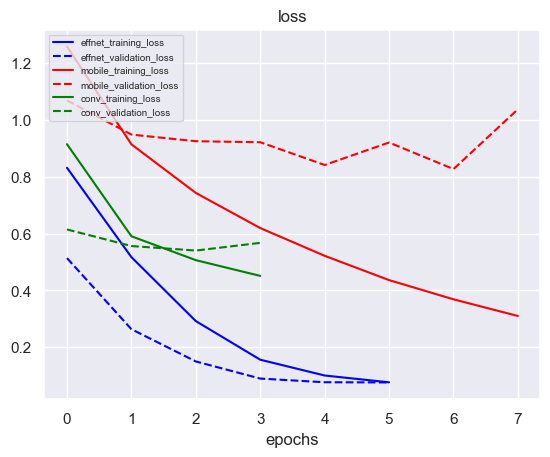

In [98]:
plt.plot(epochs_eff, loss_eff, label= "effnet_training_loss", color='blue')
plt.plot(epochs_eff, val_loss_eff, label='effnet_validation_loss',color='blue', linestyle='--')
plt.plot(epochs_mobile, loss_mobile, label= "mobile_training_loss", color='red')
plt.plot(epochs_mobile, val_loss_mobile, label='mobile_validation_loss',color='red', linestyle='--')
plt.plot(epochs_conv, loss_conv, label= "conv_training_loss", color='green')
plt.plot(epochs_conv, val_loss_conv, label='conv_validation_loss',color='green', linestyle='--')
plt.title('loss')
plt.xlabel("epochs")
plt.legend(loc="upper left", prop = { "size": 7 })
plt.show()

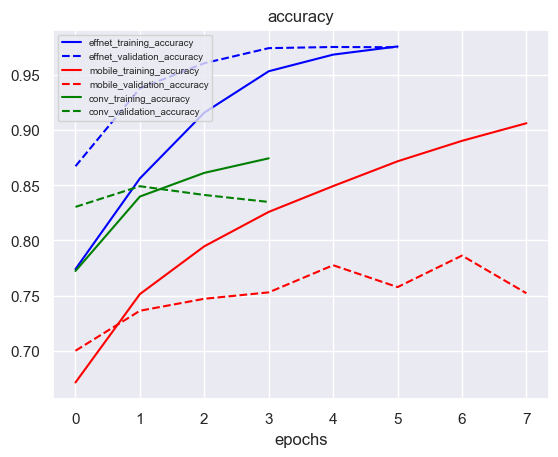

In [97]:
plt.figure()
plt.plot(epochs_eff, accuracy_eff, label= "effnet_training_accuracy", color='blue')
plt.plot(epochs_eff, val_accuracy_eff, label='effnet_validation_accuracy',color='blue', linestyle='--')
plt.plot(epochs_mobile, accuracy_mobile, label= "mobile_training_accuracy", color='red')
plt.plot(epochs_mobile, val_accuracy_mobile, label='mobile_validation_accuracy',color='red', linestyle='--')
plt.plot(epochs_conv, accuracy_conv, label= "conv_training_accuracy", color='green')
plt.plot(epochs_conv, val_accuracy_conv, label='conv_validation_accuracy',color='green', linestyle='--')
plt.title('accuracy')
plt.xlabel("epochs")
plt.legend(loc="upper left", prop = { "size": 7 })
plt.show()

Evaluating the three highest performing models, efficientnet, mobilenet, and convnextbase. It appears that with efficient net the worry may be that the model looks to be highly overfit to the training and validation set with 97% accuracy for both. 

Convnextbase looks like it has the least overfit while still having solid performance on the validation set

#### Testing Set Performance Comparison

In [105]:
models = ["MobileNetV3", "InceptionV3", "EfficientNetB0", "ResNet50", "ResNet101", "DenseNet201", "ConvNeXtBase"]
losses = [mobile_loss, incept_loss, eff_loss, net50_loss, net101_loss, dense_loss, conv_loss]
accuracies = [mobile_accuracy, incept_accuracy, eff_accuracy, net50_accuracy, net101_accuracy, dense_accuracy, conv_accuracy]
test_results = pd.DataFrame({'model': models, 'loss': losses, 'accuracy': accuracies})
display(test_results)

model      loss  accuracy
0     MobileNetV3  0.790771  0.802590
1     InceptionV3  0.987353  0.735871
2  EfficientNetB0  1.188760  0.771281
3        ResNet50  1.005330  0.726320
4       ResNet101  1.031855  0.728649
5     DenseNet201  1.004592  0.725481
6    ConvNeXtBase  0.429783  0.876811

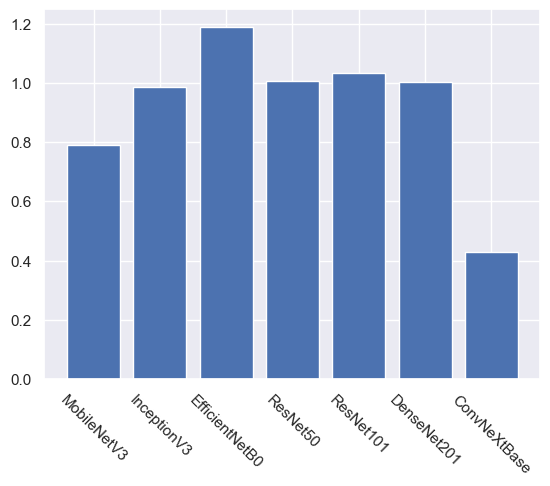

In [118]:
plt.bar(test_results['model'], test_results['loss'])
plt.xticks(rotation = 315)
plt.show()

ConvNextBase minimized loss the best out of all the models on the test set. Surpisingly, Efficient nets loss was quite high despite it's respectably high accuracy. 

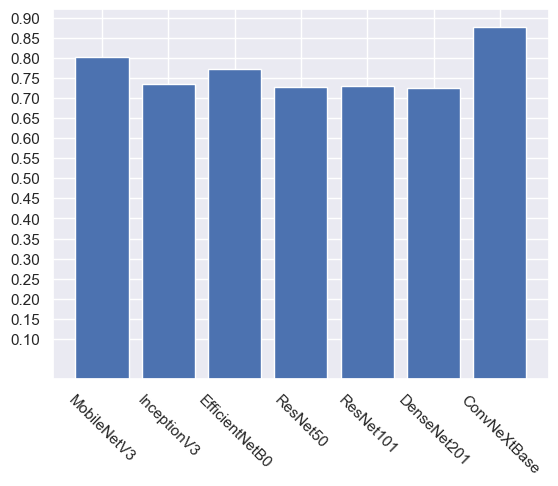

In [125]:
plt.bar(test_results['model'], test_results['accuracy'])
plt.xticks(rotation = 315)
plt.yticks(np.arange(.1, .95, 0.05))
plt.show()

Three models fit our hypothesis to move forward with API construction. We desired to build a model with 75% overall accuracy and Convnextbase, efficientnet, and mobilenet all reached the accuracy. 

Ultimately ConvNexTbase outperforms the other two models by greater than 8% and will be used for deployment moving forwards. In the event that the convnextbase is too computationally expensive for deployment to users, the MobileNetV3 will be the next choice as it offered the 2nd highest accuracy with less overfit. It also is 15mb in total compared to convnextbase ~340mb in size.